In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import spline
import pandas as pd   
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
keras.__version__

'2.1.5'

In [3]:
tensorflow.__version__

'1.7.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

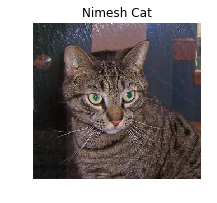

In [5]:
img = load_img('../input/cat-and-dog/training_set/training_set/cats/cat.1.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Nimesh Cat')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

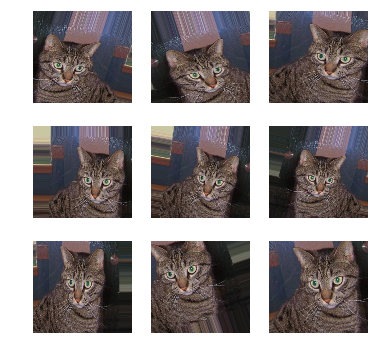

In [7]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

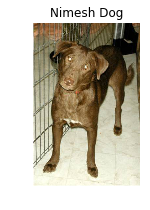

In [8]:
img = load_img('../input/cat-and-dog/training_set/training_set/dogs/dog.1.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Nimesh Dog')
plt.show()

In [9]:
# default settings
img_width, img_height = 224, 224

train_dir = '../input/cat-and-dog/training_set/training_set'
validate_dir = '../input/cat-and-dog/test_set/test_set/'
nb_epochs = 2
batch_size = 1
nb_classes = len(glob.glob(train_dir + '/*'))

In [10]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

8007


In [11]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

2025


In [12]:

# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [13]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 8005 images belonging to 2 classes.


In [15]:

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 2023 images belonging to 2 classes.


In [16]:
# this will copy the pretrained weights to our kernel
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists


In [17]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = vgg16_model.input, output = predictions)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [18]:
# freeze all layers of the pre-trained model
for layer in vgg16_model.layers:
    layer.trainable = False

In [19]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [20]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., class_weight="auto", steps_per_epoch=8007, epochs=2, validation_steps=2025)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/2
8007/8007 [==============================] - 4417s 552ms/step - loss: 0.4113 - acc: 0.8252 - val_loss: 0.2935 - val_acc: 0.8612
Epoch 2/2
4416/8007 [===============>..............] - ETA: 26:26 - loss: 0.3534 - acc: 0.8625

In [21]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3347600558912053
Test Accuracy: 0.8755555555555555


In [22]:
# save transfer learning model for offline prediction purposes
model.save('dogsandcat_vgg16_model_tl.h5')

In [23]:
validate_generator.total_batches_seen

6108

In [24]:
predict_files = glob.glob("../input/cat-and-dog/test_set/test_set/cats/*.jpg")

In [25]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [26]:

predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])


In [27]:
final = pd.DataFrame()
final["id"] = image_id
final["Cats"] = predictor 
final.head(100)

,id,Cats
0,../input/cat-and-dog/test_set/test_set/cats/ca...,1
1,../input/cat-and-dog/test_set/test_set/cats/ca...,0
2,../input/cat-and-dog/test_set/test_set/cats/ca...,0
3,../input/cat-and-dog/test_set/test_set/cats/ca...,0
4,../input/cat-and-dog/test_set/test_set/cats/ca...,0
5,../input/cat-and-dog/test_set/test_set/cats/ca...,0
6,../input/cat-and-dog/test_set/test_set/cats/ca...,0
7,../input/cat-and-dog/test_set/test_set/cats/ca...,0
8,../input/cat-and-dog/test_set/test_set/cats/ca...,0
9,../input/cat-and-dog/test_set/test_set/cats/ca...,1


In [28]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [29]:
final["Cats"] = final["Cats"].apply(lambda x: classes[x])
final.head(100)

,id,Cats
0,../input/cat-and-dog/test_set/test_set/cats/ca...,dogs
1,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
2,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
3,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
4,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
5,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
6,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
7,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
8,../input/cat-and-dog/test_set/test_set/cats/ca...,cats
9,../input/cat-and-dog/test_set/test_set/cats/ca...,dogs
